# Tutorial for Dynamic Obstacle Avoidance
This tutorial is based on following publications: 
> Huber, Lukas, Aude Billard, and Jean-Jacques E. Slotine. "Avoidance of Convex and Concave Obstacles with Convergence ensured through Contraction." IEEE Robotics and Automation Letters (2019).

> Khansari-Zadeh, Seyed Mohammad, and Aude Billard. "A dynamical system approach to realtime obstacle avoidance." Autonomous Robots 32.4 (2012): 433-454.

The initial dynamical system $\vec f(\xi)$ is modulated to get the final dynamics $\dot \xi$:

$$\dot \xi = M(\xi) \vec f(\xi)$$ 


with Modulation Matrix $M(\xi) = E(\xi)D(\xi )E(\xi)^{−1}$

### Instructions - Notebook

This tutorial is based on jupyter notebook with python code at the backend. The source code can be found under 
https://github.com/hubernikus/dynamic_obstacle_avoidance_python

The notebook can be executed online with the link:
https://mybinder.org/v2/gh/hubernikus/dynamic_obstacle_avoidance_python/master

This notebook contains a mix of text and code. In order to execute the code, click on the containing field and press CTRL + RETURN. 

In [2]:
# General classes
import numpy as np
from numpy import pi
import copy

from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import FloatSlider, IntSlider
import ipywidgets as widgets

# import warnings
# warnings.filterwarnings('ignore')

# Uncomment in case of error
import sys, os
sys.path.append(os.path.join(os.path.dirname(sys.path[0]),'src'))

from dynamic_obstacle_avoidance.dynamical_system import *
from dynamic_obstacle_avoidance.obstacle_avoidance.obstacle import Obstacle
from dynamic_obstacle_avoidance.visualization.vector_field_visualization import Simulation_vectorFields
from dynamic_obstacle_avoidance.visualization.animated_simulation import *
from dynamic_obstacle_avoidance.visualization.animated_simulation_ipython import *
from dynamic_obstacle_avoidance.visualization.widget_function_vectorfield import *

## Obstacle Description
The obstacle avoidance algorithm is able to avoida all convex and certain concave obstacles. 
Run the script bellow to change the properties of an ellipse and see how the initially linear DS.

In [4]:
#%matplotlib gtk
x_lim = [-16, 16]
y_lim = [-2, 18]

x1_widget = FloatSlider(description='Position \( x_1\)', min=x_lim[0], max=x_lim[1], step=0.1, value=6)
x2_widget = FloatSlider(description='Position \( x_2\)', min=y_lim[0], max=y_lim[1], step=0.1, value=8)

axis_widget1 = FloatSlider(description='Axis length 1', min=0.1, max=8, step=0.1, value=5)
axis_widget2 = FloatSlider(description='Axis length 2', min=0.1, max=8, step=0.1, value=3)

curvature_widget1 = IntSlider(description='Curvature 1', min=1, max=5, value=3)
curvature_widget2 = IntSlider(description='Curvature 2', min=1, max=5, value=1)

margin_widget = FloatSlider(description='Safety Margin', min=1, max=3, step=0.1, value=1.2)

angle_widget = FloatSlider(description='Orientation', min=-180, max=180, step=1, value=30)

pointX_widget = FloatSlider(description='Point position x', min=x_lim[0], max=x_lim[1], step=0.1, value=-3)
pointY_widget = FloatSlider(description='Point position y', min=y_lim[0], max=y_lim[1], step=0.1, value=15)

print("Change parameters and press <<Run Interact>> to apply.")

interact_manual(widget_ellipses_vectorfield, x1=x1_widget, x2=x2_widget,
                th_r=angle_widget,
                a1=axis_widget1, a2=axis_widget2,
                p1=curvature_widget1, p2=curvature_widget2,
                sf=margin_widget,
                draw_vectorField=True,
                point_posX=pointX_widget, point_posY=pointY_widget,
                x_low=fixed(x_lim[0]), x_high=fixed(x_lim[1]), 
                y_low=fixed(y_lim[0]), y_high=fixed(y_lim[1]));

Change parameters and press <<Run Interact>> to apply.


interactive(children=(FloatSlider(value=6.0, description='Position \\( x_1\\)', max=16.0, min=-16.0), FloatSli…

## Reference Point
The basis matrix $E(\xi)=\left[ {\vec r }(\xi) \;\; \vec e_1(\xi) \;\; .. \;\; \vec{e}_{d-1}(\xi) \right]$ decomposes the initial dynamical system into tangent directions $\vec e_i(\xi) \;\; i=1..d-1$ and reference direction $\vec r(\xi)$.

The diagonal eigenvalue matrix $ D(\xi) =
  \textbf{diag} \left( \lambda_r(\xi) , \lambda_e(\xi) , .. , \lambda_{e}( \xi) \right) $ stretches the dynamical system along the tangent direction, and compresses along the reference direction.
  
This results in provable avoidance with convergence towards the attractor.

*** Change the parameters of the reference point (direction & excentricity) and see how the modulated DS behaves. What can you observe? How is this dependent on the direction and position of the obstacle? ***

In [13]:
x_lim, y_lim = [-16, 16], [-2, 18]

# Interactive Widgets
x1_widget = FloatSlider(description='Position \( x_1\)', min=x_lim[0], max=x_lim[1], step=0.1, value=6)
x2_widget = FloatSlider(description='Position \( x_2\)', min=y_lim[0], max=y_lim[1], step=0.1, value=8)
angle_widget = FloatSlider(description='Orientation', min=-180, max=180, step=1, value=80)
referencePoint_direction = FloatSlider(description='Direction', min=-180, max=180, step=1, value=0)
referencePoint_excentricity = FloatSlider(description='Excentricity', min=0, max=0.999, step=0.01, value=0.5)

# Main function
interact_manual(widgetFunction_referencePoint, x1=x1_widget, x2=x2_widget,
                th_r=angle_widget,
                refPoint_dir=referencePoint_direction, refPoint_rat=referencePoint_excentricity,
               x_low=fixed(x_lim[0]), x_high=fixed(x_lim[1]), 
                y_low=fixed(y_lim[0]), y_high=fixed(y_lim[1]));

# Change parameters and press <<Run Interact>> to apply.

interactive(children=(FloatSlider(value=6.0, description='Position \\( x_1\\)', max=16.0, min=-16.0), FloatSli…


## Intersecting Obstacles
If you might have observed in the past interaction, the reference point decides the line where the DS is split and moves around the obstacle. This can now be extended to interscting obstacles, if they share a commond attractor they can 

1. Can you find one commond reference point of the obstacles, without having their body intersect (but only the safety maring)?
2. For 2, 3 & 4 obstacles?
3. What at happens if 3 or 4 obstacles build a chain, but do not have one comomnd reference point? Can you observe the local minma? What could be proposed to solve this problem?
4. Are there solution with several reference point with 4 obstacles with full convergence?

In [14]:
%matplotlib inline

x_lim, y_lim = [-16, 16], [-2, 18]

# Interactive Widgets
center1_widget1 = FloatSlider(description='Position \( x_1\)', min=x_lim[0], max=x_lim[1], step=0.1, value=-14)
center2_widget1 = FloatSlider(description='Position \( x_2\)', min=y_lim[0], max=y_lim[1], step=0.1, value=4)
angle_widget1 = FloatSlider(description='Orientation', min=-180, max=180, step=1, value=45)

center1_widget2 = FloatSlider(description='Position \( x_1\)', min=x_lim[0], max=x_lim[1], step=0.1, value=-3)
center2_widget2 = FloatSlider(description='Position \( x_2\)', min=y_lim[0], max=y_lim[1], step=0.1, value=10)
angle_widget2 = FloatSlider(description='Orientation', min=-180, max=180, step=1, value=0)

center1_widget3 = FloatSlider(description='Position \( x_1\)', min=x_lim[0], max=x_lim[1], step=0.1, value=6)
center2_widget3 = FloatSlider(description='Position \( x_2\)', min=y_lim[0], max=y_lim[1], step=0.1, value=4)
angle_widget3 = FloatSlider(description='Orientation', min=-180, max=180, step=1, value=-80)

center1_widget4 = FloatSlider(description='Position \( x_1\)', min=x_lim[0], max=x_lim[1], step=0.1, value=10)
center2_widget4 = FloatSlider(description='Position \( x_2\)', min=y_lim[0], max=y_lim[1], step=0.1, value=14)
angle_widget4 = FloatSlider(description='Orientation', min=-180, max=180, step=1, value=-110)


def choose_obstacles(n_obstacles):
    # Main function
    if n_obstacles ==2:
          interact_manual(widgetFunction_intersection, n_obstacles=fixed(n_obstacles),
            center1_1=center1_widget1, center2_1=center2_widget1, orientation_1=angle_widget1,
            center1_2=center1_widget2, center2_2=center2_widget2, orientation_2=angle_widget2,
            center1_3=fixed(0), center2_3=fixed(0), orientation_3=fixed(0),
            center1_4=fixed(0), center2_4=fixed(0), orientation_4=fixed(0),
            x_low=fixed(x_lim[0]), x_high=fixed(x_lim[1]), y_low=fixed(y_lim[0]), y_high=fixed(y_lim[1]));
    elif n_obstacles==3:
        interact_manual(widgetFunction_intersection, n_obstacles=fixed(n_obstacles),
            center1_1=center1_widget1, center2_1=center2_widget1, orientation_1=angle_widget1,
            center1_2=center1_widget2, center2_2=center2_widget2, orientation_2=angle_widget2,
            center1_3=center1_widget3, center2_3=center2_widget3, orientation_3=angle_widget3,
            center1_4=fixed(0), center2_4=fixed(0), orientation_4=fixed(0),
            x_low=fixed(x_lim[0]), x_high=fixed(x_lim[1]), y_low=fixed(y_lim[0]), y_high=fixed(y_lim[1]));
    elif n_obstacles==4:
        interact_manual(widgetFunction_intersection, n_obstacles=fixed(n_obstacles),
            center1_1=center1_widget1, center2_1=center2_widget1, orientation_1=angle_widget1,
            center1_2=center1_widget2, center2_2=center2_widget2, orientation_2=angle_widget2,
            center1_3=center1_widget3, center2_3=center2_widget3, orientation_3=angle_widget3,
            center1_4=center1_widget4, center2_4=center2_widget4, orientation_4=angle_widget4,
            x_low=fixed(x_lim[0]), x_high=fixed(x_lim[1]), y_low=fixed(y_lim[0]), y_high=fixed(y_lim[1]));
        
n_obs_widget = IntSlider(description='Number of obstacles', min=2, max=4, value=2)
n_obs_widget = widgets.Dropdown(
    options=[2,3,4],
    value=2,
    description='Obstacle Number:',
    disabled=False,
)

print("Change parameters and press <<Run Interact>> to apply.")
interact(choose_obstacles, n_obstacles=n_obs_widget);
                


Change parameters and press <<Run Interact>> to apply.


interactive(children=(Dropdown(description='Obstacle Number:', options=(2, 3, 4), value=2), Output()), _dom_cl…

# Dynamic Obstacle Avoidance


this is ipython
done this
ended that
Returning animation object


<IPython.core.display.Javascript object>


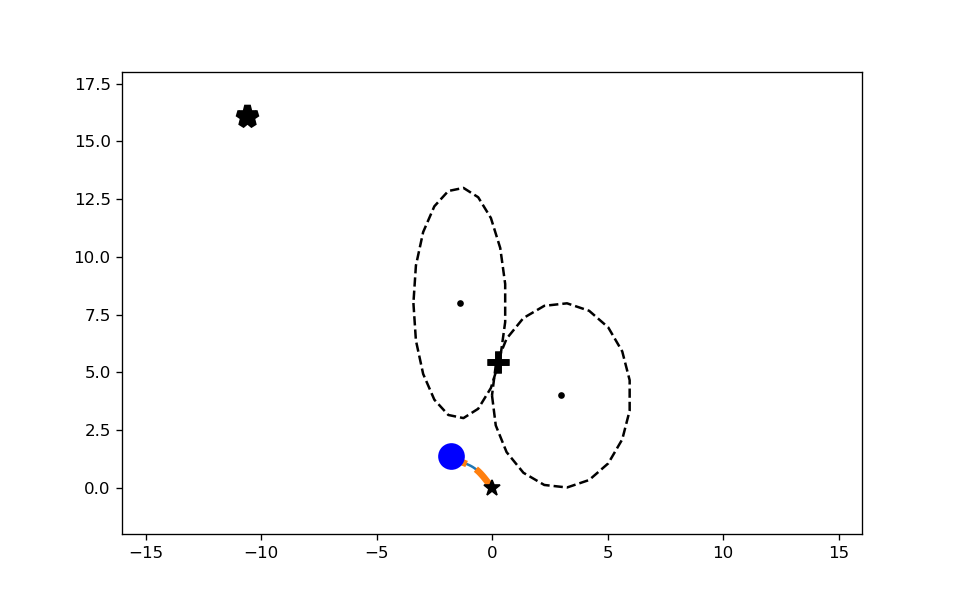

interactive(children=(Dropdown(description='Obstacle Numhber:', options=(0, 1), value=0), FloatSlider(value=0.…

NOTE - After executing this window, all graphics will appear in pop up windows. 


In [21]:
#%matplotlib tk
#import matplotlib.pyplot
#matplotlib.pyplot.switch_backend("TkAgg")

%matplotlib notebook

x_range, y_range = [-16, 16], [-2, 18]
x_init = samplePointsAtBorder(number_of_points=10, x_range=x_range, y_range=y_range)

x_init = np.zeros((2,1))
x_init[:,0] = [8, 1]

obs = []
x0=[-3, 8]
a=[2, 5]
p=[1,1]
th_r=0/180*pi
vel = [0, 0]
obs.append(Obstacle(a=a, p=p, x0=x0, th_r=th_r, sf=1))

x0=[3, 4]
a=[3, 4]
p=[1,1]
th_r=0/180*pi
vel = [0, 0]
obs.append(Obstacle(a=a, p=p, x0=x0, th_r=th_r, sf=1))


# %matplotlib notebook
ani = run_animation_ipython(x_init, obs=obs, x_range=x_range, y_range=y_range, 
              dt=0.005, N_simuMax=1000, convergenceMargin=0.3, sleepPeriod=0.001, 
              RK4_int=True, hide_ticks=False, return_animationObject=True)
plt.ion()
ani.show()


velx_widget = FloatSlider(description='Vel x \( \dot  x_1\)', min=-5.0, max=5.0, step=0.1, value=0)

velx_widget = FloatSlider(description='Vel x \( \dot  x_1\)', min=-5.0, max=5.0, step=0.1, value=0)
vely_widget = FloatSlider(description='Vel y \( \dot  x_1\)', min=-5.0, max=5.0, step=0.1, value=0)
velAng_widget = FloatSlider(description='Vel Ang \( \omega\)', min=-5.0, max=5.0, step=0.1, value=0)

obs_number = IntSlider(description='Obstacle Number', min=0, max=len(obs)-1, value=0)

obs_number = widgets.Dropdown(
    options=[ii for ii in range(len(obs))],
    value=0,
    description='Obstacle Numhber:',
    disabled=False,
)
interact_manual(ani.set_velocity, obs_number=obs_number, vel_x =velx_widget, vel_y=vely_widget, vel_rot=velAng_widget)

print("NOTE - After executing this window, all graphics will appear in pop up windows. ")
# To reverse this, reload the kernel/page.
# Click on the figure to pause it
# Change the dynamic paramters for each of the obstacles indiviudally